# Golden Cross / Death Cross S&P 500 index (^GSPC)

    1. sma50>sma200, buy
    2. sma50<sma200, sell your long position.
    
    THIS IS MEANT FOR EDUCATIONAL PURPOSES.  The condensed version is in strategy.ipynb

In [1]:
import datetime

import matplotlib.pyplot as plt
import pandas as pd
from talib.abstract import *

import pinkfish as pf

# Format price data
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# Set size of inline plots
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

Some global data

In [3]:
#symbol = '^GSPC'
symbol = 'SPY'
#symbol = '^DJI'
#symbol = 'DJA'
#symbol = 'DIA'
#symbol = 'QQQ'
#symbol = 'IWM'
#symbol = 'TLT'
#symbol = 'GLD'
#symbol = 'AAPL'
#symbol = 'BBRY'
capital = 10000
#start = datetime.datetime(1900, 1, 1)
start = datetime.datetime(*pf.SP500_BEGIN)
end = datetime.datetime.now()

Include dividends? (If yes, set to True)

In [4]:
use_adj = True

Fetch symbol data from internet; use cache if available.

In [5]:
ts = pf.fetch_timeseries(symbol)
ts.head()

,high,low,open,close,volume,adj_close
date,,,,,,
1993-01-29,43.97,43.75,43.97,43.94,1003200.00,25.88
1993-02-01,44.25,43.97,43.97,44.25,480500.00,26.07
1993-02-02,44.38,44.12,44.22,44.34,201300.00,26.12
1993-02-03,44.84,44.38,44.41,44.81,529400.00,26.40
1993-02-04,45.09,44.47,44.97,45.00,531500.00,26.51


Select timeseries between start and end. Back adjust prices relative to adj_close for dividends and splits.

In [6]:
ts = pf.select_tradeperiod(ts, start, end, use_adj)
ts.head()

,high,low,open,close,volume,adj_close
date,,,,,,
1993-01-29,25.90,25.77,25.90,25.88,1003200.00,25.88
1993-02-01,26.07,25.90,25.90,26.07,480500.00,26.07
1993-02-02,26.14,25.99,26.05,26.12,201300.00,26.12
1993-02-03,26.42,26.14,26.16,26.40,529400.00,26.40
1993-02-04,26.57,26.20,26.49,26.51,531500.00,26.51


Add technical indicator: 50 day ma and 200 day ma

In [7]:
sma50 = SMA(ts, timeperiod=50)
ts['sma50'] = sma50

sma200 = SMA(ts, timeperiod=200)
ts['sma200'] = sma200

ts.head()

,high,low,open,close,volume,adj_close,sma50,sma200
date,,,,,,,,
1993-01-29,25.90,25.77,25.90,25.88,1003200.00,25.88,nan,nan
1993-02-01,26.07,25.90,25.90,26.07,480500.00,26.07,nan,nan
1993-02-02,26.14,25.99,26.05,26.12,201300.00,26.12,nan,nan
1993-02-03,26.42,26.14,26.16,26.40,529400.00,26.40,nan,nan
1993-02-04,26.57,26.20,26.49,26.51,531500.00,26.51,nan,nan


Finalize the time series before implementing trading strategy

In [8]:
ts, start = pf.finalize_timeseries(ts, start)
ts.head()

,high,low,open,close,volume,adj_close,sma50,sma200
date,,,,,,,,
1993-11-11,27.97,27.80,27.89,27.82,88900.00,27.82,27.72,26.87
1993-11-12,28.04,27.85,27.87,27.95,108200.00,27.95,27.72,26.88
1993-11-15,28.00,27.85,28.00,27.93,243300.00,27.93,27.73,26.89
1993-11-16,28.08,27.87,27.98,28.06,492600.00,28.06,27.74,26.90
1993-11-17,28.08,27.83,28.08,27.91,39600.00,27.91,27.75,26.91


Plot closing price along with moving averages

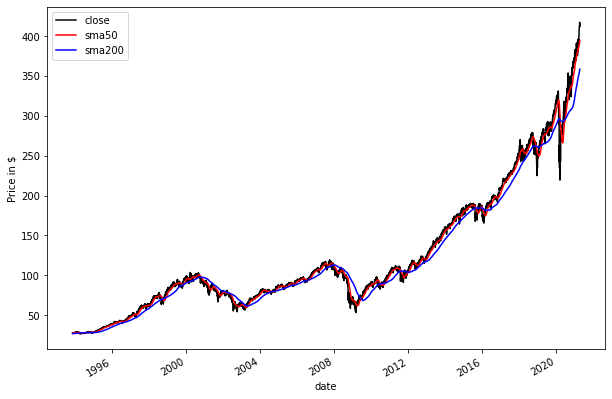

In [9]:
fig = plt.figure()
axes = fig.add_subplot(111,  ylabel='Price in $')

ts['close'].plot(ax=axes, label='close', color='k')
ts['sma50'].plot(ax=axes, label='sma50', color='r')
ts['sma200'].plot(ax=axes, label='sma200', color='b')
plt.legend(loc='best')

Create Trade Log (tlog); Create Daily Balance (dbal)

In [10]:
tlog = pf.TradeLog(symbol)
dbal = pf.DailyBal()

Algo: Buy when 50 day ma crosses above 200 day ma.  Sell when 50 day ma crosses below 200 day ma. 

In [11]:
pf.TradeLog.cash = capital

import time
t0 = time.time()

"""
# This is the slowest (2.42 s)
for i in range(len(ts.index)):

    date = ts.index[i]
    high = ts['high'][i]
    low = ts['low'][i]
    close = ts['close'][i]
    sma50 = ts['sma50'][i]
    sma200 = ts['sma200'][i]

# This is still slow (2.53 s)
for i, (index, row) in enumerate(ts.iterrows()):

    date = index
    high = row['high']
    low = row['low']
    close = row['close']
    sma50 = row['sma50']
    sma200 = row['sma200']


# using .at[] is fast (832 ms)
for i, index in enumerate(ts.index):

    date = index
    high = ts.at[index, 'high']
    low = ts.at[index, 'low']
    close = ts.at[index, 'close']
    sma50 = ts.at[index, 'sma50']
    sma200 = ts.at[index, 'sma200']

# using itertuples is fastest for looping (378 ms)
for i, row in enumerate(ts.itertuples()):

    date = row.Index.to_pydatetime()
    high = row.high
    low = row.low
    close = row.close
    sma50 = row.sma50
    sma200 = row.sma200
"""

for i, row in enumerate(ts.itertuples()):

    date = row.Index.to_pydatetime()
    high = row.high; low = row.low; close = row.close; 
    end_flag = pf.is_last_row(ts, i)
    shares = 0
    
    # Buy
    if tlog.shares == 0:
        if row.sma50 > row.sma200 and ts['sma50'][i-1] <= ts['sma200'][i-1]:
            # Enter buy in trade log
            shares = tlog.buy(date, close)  
    # Sell
    else:
        if ((row.sma50 < row.sma200 and ts['sma50'][i-1] >= ts['sma200'][i-1])
            or end_flag):
            # Enter sell in trade log
            shares = tlog.sell(date, close)

    if shares > 0:
        print("{0} BUY  {1} {2} @ {3:.2f}".format(
              date, shares, symbol, close))
    elif shares < 0:
        print("{0} SELL {1} {2} @ {3:.2f}".format(
              date, -shares, symbol, close))

    # Record daily balance
    dbal.append(date, high, low, close)  

t1 = time.time()
total = t1-t0
print(total)
        

1994-09-01 00:00:00 BUY  344 SPY @ 29.04
1998-10-01 00:00:00 SELL 344 SPY @ 65.54
1998-12-04 00:00:00 BUY  287 SPY @ 78.51
2000-11-02 00:00:00 SELL 287 SPY @ 96.70
2002-04-19 00:00:00 BUY  356 SPY @ 77.93
2002-05-17 00:00:00 SELL 356 SPY @ 76.56
2003-05-12 00:00:00 BUY  409 SPY @ 66.62
2004-08-25 00:00:00 SELL 409 SPY @ 79.53
2004-10-27 00:00:00 BUY  401 SPY @ 81.14
2006-07-25 00:00:00 SELL 401 SPY @ 94.15
2006-08-29 00:00:00 BUY  389 SPY @ 97.06
2007-12-28 00:00:00 SELL 389 SPY @ 112.62
2009-06-18 00:00:00 BUY  602 SPY @ 72.72
2010-07-07 00:00:00 SELL 602 SPY @ 85.76
2010-10-13 00:00:00 BUY  539 SPY @ 95.82
2011-08-17 00:00:00 SELL 539 SPY @ 98.66
2012-01-23 00:00:00 BUY  484 SPY @ 109.76
2015-09-03 00:00:00 SELL 484 SPY @ 175.01
2015-12-09 00:00:00 BUY  459 SPY @ 184.73
2016-01-15 00:00:00 SELL 459 SPY @ 169.96
2016-04-20 00:00:00 BUY  408 SPY @ 191.12
2018-12-12 00:00:00 SELL 408 SPY @ 253.44
2019-03-26 00:00:00 BUY  381 SPY @ 271.14
2020-03-31 00:00:00 SELL 381 SPY @ 253.68
2020-07

Retrieve raw log and trade log DataFrames

In [12]:
rlog = tlog.get_log_raw()
tlog = tlog.get_log()

In [13]:
rlog.tail()

,date,seq_num,price,shares,entry_exit,direction,symbol
21,2018-12-12,21,253.44,408,exit,LONG,SPY
22,2019-03-26,22,271.14,381,entry,LONG,SPY
23,2020-03-31,23,253.68,381,exit,LONG,SPY
24,2020-07-06,24,313.42,308,entry,LONG,SPY
25,2021-04-20,25,412.17,308,exit,LONG,SPY


In [14]:
tlog.tail(10)

,entry_date,entry_price,exit_date,exit_price,pl_points,pl_cash,qty,cumul_total,direction,symbol
3,2003-05-12,66.62,2004-08-25,79.53,12.91,5279.48,409,22566.96,LONG,SPY
4,2004-10-27,81.14,2006-07-25,94.15,13.01,5216.87,401,27783.82,LONG,SPY
5,2006-08-29,97.06,2007-12-28,112.62,15.56,6053.95,389,33837.77,LONG,SPY
6,2009-06-18,72.72,2010-07-07,85.76,13.04,7849.11,602,41686.88,LONG,SPY
7,2010-10-13,95.82,2011-08-17,98.66,2.84,1533.33,539,43220.21,LONG,SPY
8,2012-01-23,109.76,2015-09-03,175.01,65.25,31581.59,484,74801.81,LONG,SPY
9,2015-12-09,184.73,2016-01-15,169.96,-14.76,-6777.04,459,68024.77,LONG,SPY
10,2016-04-20,191.12,2018-12-12,253.44,62.32,25426.61,408,93451.38,LONG,SPY
11,2019-03-26,271.14,2020-03-31,253.68,-17.46,-6652.62,381,86798.76,LONG,SPY
12,2020-07-06,313.42,2021-04-20,412.17,98.75,30415.30,308,117214.06,LONG,SPY


In [15]:
dbal = dbal.get_log(tlog)
dbal.tail()

,high,low,close,shares,cash,leverage,state
date,,,,,,,
2021-04-14,127765.37,126813.65,126992.30,308,265.69,1.00,-
2021-04-15,128442.97,127682.21,128353.65,308,265.69,1.00,-
2021-04-16,128981.97,128310.54,128781.77,308,265.69,1.00,-
2021-04-19,128621.61,127713.01,128150.37,308,265.69,1.00,-
2021-04-20,127214.06,127214.06,127214.06,0,127214.06,1.00,X


In [23]:
close = dbal['close']
close

date
1993-11-11    10000.00
1993-11-12    10000.00
1993-11-15    10000.00
1993-11-16    10000.00
1993-11-17    10000.00
                ...   
2021-04-14   126992.30
2021-04-15   128353.65
2021-04-16   128781.77
2021-04-19   128150.37
2021-04-20   127214.06
Name: close, Length: 6908, dtype: float64

In [24]:
running_max = pd.Series(close).expanding(min_periods=1).max()
running_max

date
1993-11-11    10000.00
1993-11-12    10000.00
1993-11-15    10000.00
1993-11-16    10000.00
1993-11-17    10000.00
                ...   
2021-04-14   127426.57
2021-04-15   128353.65
2021-04-16   128781.77
2021-04-19   128781.77
2021-04-20   128781.77
Name: close, Length: 6908, dtype: float64

In [29]:
cur_dd = (close - running_max) / running_max * 100
cur_dd.tail(50)

date
2021-02-08   -4.85
2021-02-09   -4.92
2021-02-10   -4.96
2021-02-11   -4.80
2021-02-12   -4.33
2021-02-16   -4.42
2021-02-17   -4.40
2021-02-18   -4.80
2021-02-19   -4.97
2021-02-22   -5.70
2021-02-23   -5.58
2021-02-24   -4.55
2021-02-25   -6.84
2021-02-26   -7.32
2021-03-01   -5.08
2021-03-02   -5.82
2021-03-03   -7.06
2021-03-04   -8.21
2021-03-05   -6.52
2021-03-08   -6.99
2021-03-09   -5.66
2021-03-10   -5.08
2021-03-11   -4.12
2021-03-12   -3.99
2021-03-15   -3.42
2021-03-16   -3.54
2021-03-17   -3.21
2021-03-18   -4.62
2021-03-19   -4.79
2021-03-22   -4.03
2021-03-23   -4.79
2021-03-24   -5.27
2021-03-25   -4.74
2021-03-26   -3.21
2021-03-29   -3.26
2021-03-30   -3.51
2021-03-31   -3.12
2021-04-01   -2.08
2021-04-05   -0.68
2021-04-06   -0.73
2021-04-07   -0.62
2021-04-08   -0.15
2021-04-09    0.00
2021-04-12    0.00
2021-04-13    0.00
2021-04-14   -0.34
2021-04-15    0.00
2021-04-16    0.00
2021-04-19   -0.49
2021-04-20   -1.22
Name: close, dtype: float64

In [30]:
dd_max = min(0, cur_dd.min())
dd_max

-33.67827569602462

In [31]:
idx = cur_dd.idxmin()
idx

Timestamp('2020-03-23 00:00:00')

In [21]:
def max_closed_out_drawdown(close):
    """
    Only compare each point to the previous running peak O(N).
    """
    running_max = pd.Series(close).expanding(min_periods=1).max()
    cur_dd = (close - running_max) / running_max * 100
    dd_max = min(0, cur_dd.min())
    idx = cur_dd.idxmin()

    dd = pd.Series(dtype='object')
    dd['max'] = dd_max
    dd['peak'] = running_max[idx]
    dd['trough'] = close[idx]
    dd['peak_date'] = close[close == dd['peak']].index[0].strftime('%Y-%m-%d')
    dd['trough_date'] = idx.strftime('%Y-%m-%d')
    close = close[close.index > idx]

    rd_mask = close > dd['peak']
    if rd_mask.any():
        dd['recovery_date'] = close[rd_mask].index[0].strftime('%Y-%m-%d')
    else:
        dd['recovery_date'] = 'Not Recovered Yet'

    return dd

In [22]:
dd = max_closed_out_drawdown(dbal['close'])
dd

max                  -33.68
peak              126277.21
trough             83749.22
peak_date        2020-02-19
trough_date      2020-03-23
recovery_date    2021-04-09
dtype: object

Generate strategy stats - display all available stats

In [16]:
stats = pf.stats(ts, tlog, dbal, capital)
pf.print_full(stats)

start                                                   1993-11-11
end                                                     2021-04-01
beginning_balance                                            10000
ending_balance                                           123456.45
total_net_profit                                         113456.45
gross_profit                                             127372.75
gross_loss                                               -13916.29
profit_factor                                                 9.15
return_on_initial_capital                                  1134.56
annual_return_rate                                            9.61
trading_period                           27 years 4 months 21 days
pct_time_in_market                                           74.75
margin                                                           1
avg_leverage                                                  1.00
max_leverage                                                  

Run Benchmark

In [17]:
benchmark = pf.Benchmark(symbol, capital, start, end, use_adj)
benchmark.run()

Plot Equity Curves: Strategy vs Benchmark

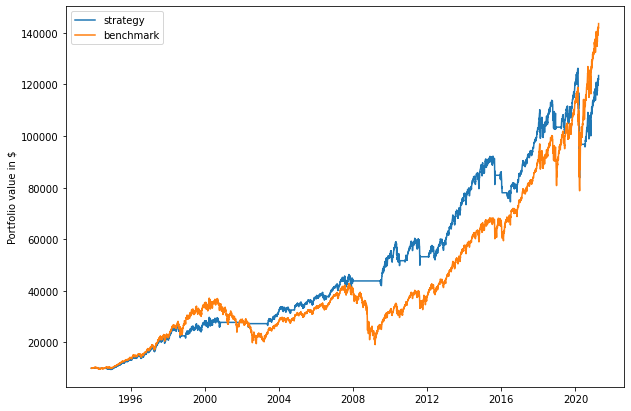

In [18]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal)

Plot Trades

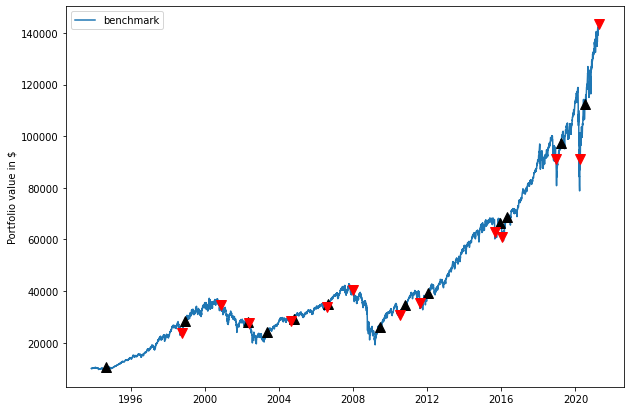

In [19]:
pf.plot_trades(dbal, benchmark=benchmark.dbal)

Strategy vs Benchmark

In [20]:
df = pf.summary(stats, benchmark.stats, metrics=pf.currency_metrics)
df

,strategy,benchmark
beginning_balance,"$10,000.00","$10,000.00"
ending_balance,"$123,456.45","$143,603.31"
total_net_profit,"$113,456.45","$133,603.31"
gross_profit,"$127,372.75","$133,603.31"
gross_loss,"-$13,916.29",$0.00


,strategy,benchmark
annual_return_rate,9.61,10.22
max_closed_out_drawdown,-33.68,-55.17
annualized_return_over_max_drawdown,0.29,0.19
best_month,15.58,23.60
worst_month,-30.95,-30.98
sharpe_ratio,0.73,0.61
sortino_ratio,0.78,0.77
monthly_std,3.27,4.52
annual_std,12.02,16.94
avg_month,0.78,0.88


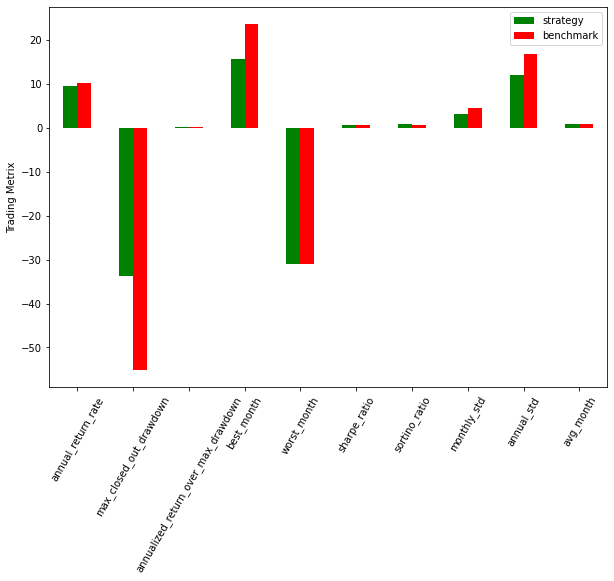

In [21]:
extras = ('avg_month',)

df = pf.plot_bar_graph(stats, benchmark.stats, extras=extras)
df